Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

DataFrames

In [2]:
#Se definen los DataFrames a utilizar con los datos limpios, es decir luego del proceso de ETL.
hechos=pd.read_csv('DATA/Limpios/Hechos.csv')
poblacion=pd.read_csv('DATA/Limpios/Poblacion.csv')
victimas=pd.read_csv('DATA/Limpios/Victimas.csv')

Debido a que en el DataFrame 'hechos' no necesariamente son todos mortales, se lo une con el DataFrame 'victimas' para obtener solo los casos en donde haya fallecido 1 o mas personas.

In [3]:
df=pd.merge(hechos, victimas, left_on='ID', right_on='ID_hecho', how='inner')
df = pd.merge(df, poblacion, on='AAAA', how='inner')
df.head()

,Unnamed: 0_x,ID,N_VICTIMAS,AAAA,MM,HH,TIPO_DE_CALLE,COMUNA,VICTIMA,ACUSADO,SEMESTRE,Unnamed: 0_y,ID_hecho,SEXO,EDAD,Unnamed: 0,POBLACION_ANUAL
0,0,2016-0001,1,2016,1,4.0,AVENIDA,8,MOTO,AUTO,2016-1,0,2016-0001,MASCULINO,19,1,3059122.0
1,1,2016-0002,1,2016,1,1.0,GRAL PAZ,9,AUTO,PASAJEROS,2016-1,1,2016-0002,MASCULINO,70,1,3059122.0
2,2,2016-0003,1,2016,1,7.0,AVENIDA,1,MOTO,AUTO,2016-1,2,2016-0003,MASCULINO,30,1,3059122.0
3,4,2016-0005,1,2016,1,5.0,AVENIDA,1,MOTO,PASAJEROS,2016-1,4,2016-0005,MASCULINO,29,1,3059122.0
4,5,2016-0008,1,2016,1,18.0,AVENIDA,8,MOTO,OBJETO FIJO,2016-1,5,2016-0008,MASCULINO,30,1,3059122.0


Se explora la composición del df.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0_x     649 non-null    int64  
 1   ID               649 non-null    object 
 2   N_VICTIMAS       649 non-null    int64  
 3   AAAA             649 non-null    int64  
 4   MM               649 non-null    int64  
 5   HH               648 non-null    float64
 6   TIPO_DE_CALLE    649 non-null    object 
 7   COMUNA           649 non-null    int64  
 8   VICTIMA          649 non-null    object 
 9   ACUSADO          649 non-null    object 
 10  SEMESTRE         649 non-null    object 
 11  Unnamed: 0_y     649 non-null    int64  
 12  ID_hecho         649 non-null    object 
 13  SEXO             649 non-null    object 
 14  EDAD             649 non-null    object 
 15  Unnamed: 0       649 non-null    int64  
 16  POBLACION_ANUAL  649 non-null    float64
dtypes: float64(2), i

Como ya sabemos nuestros KPIs, ya sabemos que columnas vamos a necesitar y cuales no. Por eso se eliminan las columnas innecesarias.

In [6]:
col_eliminar=['Unnamed: 0_x','ID','HH','TIPO_DE_CALLE','COMUNA','VICTIMA','ACUSADO','Unnamed: 0_y','SEXO','EDAD','Unnamed: 0','ID_hecho','MM','AAAA']
df.drop(columns=col_eliminar, axis=1,inplace=True)
df.head(3)

,N_VICTIMAS,SEMESTRE,POBLACION_ANUAL
0,1,2016-1,3059122.0
1,1,2016-1,3059122.0
2,1,2016-1,3059122.0


Se crea un nuevo DataFrame agrupado por semestres, ya que el KPI 1 es semestral. Este contiene los datos de cantidad de victimas y poblacion del semestre actual.

In [7]:
#Se define el df agrupando por semestre, sumando el número de víctimas y con las columna de POBLACION_ANUAL.
df_actual = df.groupby("SEMESTRE", as_index=False).agg({
    "N_VICTIMAS": "sum",
    "POBLACION_ANUAL": "first",  # Agrega "first" para conservar el valor de "POBLACION_ANUAL"
})
#Se renombran las columnas.
df_actual = df_actual.rename(columns={"N_VICTIMAS": "N_VICTIMAS_SEMESTRE",
                                      "SEMESTRE": "SEMESTRE",
                                      "POBLACION_ANUAL": "POBLACION_ANUAL"})
df_actual

,SEMESTRE,N_VICTIMAS_SEMESTRE,POBLACION_ANUAL
0,2016-1,48,3059122.0
1,2016-2,38,3059122.0
2,2017-1,80,3063728.0
3,2017-2,72,3063728.0
4,2018-1,76,3068043.0
5,2018-2,85,3068043.0
6,2019-1,59,3072029.0
7,2019-2,47,3072029.0
8,2020-1,31,3075646.0
9,2020-2,56,3075646.0


Se crea una nueva columna'SEMESTRE_ANTERIOR' ya que la vamos a necesitar, como llave, para posteriormente unirla con otro df.

In [8]:
df_actual['SEMESTRE_ANTERIOR'] = df_actual['SEMESTRE'].apply(lambda x: f"{int(x.split('-')[0])}-{int(x.split('-')[1])-1}" if x.endswith('-2') else f"{int(x.split('-')[0])-1}-2")
df_actual

,SEMESTRE,N_VICTIMAS_SEMESTRE,POBLACION_ANUAL,SEMESTRE_ANTERIOR
0,2016-1,48,3059122.0,2015-2
1,2016-2,38,3059122.0,2016-1
2,2017-1,80,3063728.0,2016-2
3,2017-2,72,3063728.0,2017-1
4,2018-1,76,3068043.0,2017-2
5,2018-2,85,3068043.0,2018-1
6,2019-1,59,3072029.0,2018-2
7,2019-2,47,3072029.0,2019-1
8,2020-1,31,3075646.0,2019-2
9,2020-2,56,3075646.0,2020-1


Se define otro DataFrame con los datos de poblacion y cantidad de víctimas, pero del semestre anterior al que estamos viendo. Es por esto que la agrupación es, de igual manera que antes, por semestre.

In [9]:
df_anterior = df.groupby("SEMESTRE", as_index=False).agg({
    "N_VICTIMAS": "sum",
    "POBLACION_ANUAL": "first",  # Agrega "first" para conservar el valor de "POBLACION_ANUAL"
})
df_anterior = df_anterior.rename(columns={"N_VICTIMAS": "N_VICTIMAS_SEMESTRE_ANTERIOR",
                                      "SEMESTRE": "SEMESTRE_ANTERIOR",
                                      "POBLACION_ANUAL": "POBLACION_ANUAL_ANTERIOR"})
df_anterior

,SEMESTRE_ANTERIOR,N_VICTIMAS_SEMESTRE_ANTERIOR,POBLACION_ANUAL_ANTERIOR
0,2016-1,48,3059122.0
1,2016-2,38,3059122.0
2,2017-1,80,3063728.0
3,2017-2,72,3063728.0
4,2018-1,76,3068043.0
5,2018-2,85,3068043.0
6,2019-1,59,3072029.0
7,2019-2,47,3072029.0
8,2020-1,31,3075646.0
9,2020-2,56,3075646.0


Por último, se unen los dos df creados anteriormente para ya tener todos los datos necesarios para nuestro KPI 1. Se unen mediante la columna 'SEMESTRE_ANTERIOR' que se, también, creó anteriormente.

In [10]:
df_KPI_1 = pd.merge(df_actual, df_anterior, on="SEMESTRE_ANTERIOR", how="inner")
df_KPI_1.head(3)

,SEMESTRE,N_VICTIMAS_SEMESTRE,POBLACION_ANUAL,SEMESTRE_ANTERIOR,N_VICTIMAS_SEMESTRE_ANTERIOR,POBLACION_ANUAL_ANTERIOR
0,2016-2,38,3059122.0,2016-1,48,3059122.0
1,2017-1,80,3063728.0,2016-2,38,3059122.0
2,2017-2,72,3063728.0,2017-1,80,3063728.0


Se calcula el valor del KPI 1 para cada semestre, mediante la fórmula ((tasa_anterior - tasa_actual) / tasa_anterior) * 100.

In [11]:
tasa_anterior = (df_KPI_1["N_VICTIMAS_SEMESTRE_ANTERIOR"] / df_KPI_1["POBLACION_ANUAL_ANTERIOR"]) * 100000
tasa_actual = (df_KPI_1["N_VICTIMAS_SEMESTRE"] / df_KPI_1["POBLACION_ANUAL"]) * 100000
df_KPI_1["KPI_1"] = (((tasa_anterior - tasa_actual) / tasa_anterior) * 100).round(2)
df_KPI_1

,SEMESTRE,N_VICTIMAS_SEMESTRE,POBLACION_ANUAL,SEMESTRE_ANTERIOR,N_VICTIMAS_SEMESTRE_ANTERIOR,POBLACION_ANUAL_ANTERIOR,KPI_1
0,2016-2,38,3059122.0,2016-1,48,3059122.0,20.83
1,2017-1,80,3063728.0,2016-2,38,3059122.0,-110.21
2,2017-2,72,3063728.0,2017-1,80,3063728.0,10.00
3,2018-1,76,3068043.0,2017-2,72,3063728.0,-5.41
4,2018-2,85,3068043.0,2018-1,76,3068043.0,-11.84
5,2019-1,59,3072029.0,2018-2,85,3068043.0,30.68
6,2019-2,47,3072029.0,2019-1,59,3072029.0,20.34
7,2020-1,31,3075646.0,2019-2,47,3072029.0,34.12
8,2020-2,56,3075646.0,2020-1,31,3075646.0,-80.65
9,2021-1,55,3078836.0,2020-2,56,3075646.0,1.89


Como se puede observar un número de KPI 1 positivo, representa una baja en la tasa de homicidios semestral. Por lo tanto, un KPI 1 negativo significa que la tasa aumentó. En ambos casos, cuanto mayor sea el módulo, mas abrupto es el cambio.

Finalmente se grafica el valor del KPI 1 en función del semstre, para visualizar mas facilmente el comportamiento.

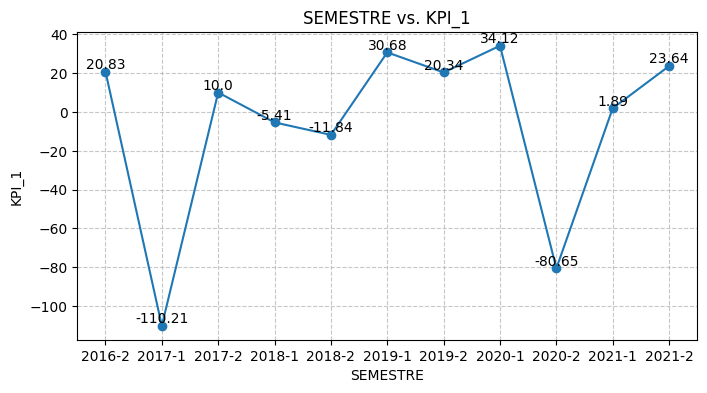

In [12]:
semestre = df_KPI_1["SEMESTRE"]
KPI = df_KPI_1["KPI_1"]
# Crear el gráfico de líneas
plt.figure(figsize=(8, 4))  # Ajusta el tamaño del gráfico si es necesario
plt.plot(semestre, KPI, marker='o', linestyle='-')
plt.title('SEMESTRE vs. KPI_1')
plt.xlabel('SEMESTRE')
plt.ylabel('KPI_1')
# Agregar etiquetas de datos (valores) sobre cada punto
for i, valor in enumerate(KPI):
    plt.text(semestre[i], valor, str(valor), ha='center', va='bottom')
# Mostrar el gráfico
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Analizando el gráfico, vemos que una pendiente negativa es igual a un aumento de la Tasa de homicidios. Por lo contario, una pendiente positiva, es una disminución en la Tasa de homicidios semestral. En el primer semestre del 2017 y el segundo semstre del 2020 hubo un aumento muy abrupto y considerable de la Tasa de homicidios a pesar de que en los semestres anteriores se venia viendo, a grandes rasgos, una mejora.
En general podemos decir que la Tasa de Homicidios semestral fue mejorando, ya que 7 puntos de 11 son positivos y 4 puntos de 11 son negativos.

Se guarda el df del KPI 1 en formato CSV

In [13]:
df_KPI_1.to_csv('KPI_1.csv')